In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, df

/home/marcello/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
# Α α, Β β, Γ γ, Δ δ, Ε ε, Ζ ζ, Η η, Θ θ, Ι ι, 
# Κ κ, Λ λ, Μ μ, Ν ν, Ξ ξ, Ο ο, Π π, Ρ ρ, Σ σ,
# Τ τ, Υ υ, Φ φ, Χ χ, Ψ ψ, Ω ω.

In [3]:
mol_h2o = gto.M(atom = """
                O 0 0 0; H 1.5 0.0 0; H 0.0 1.5 0.0;
                O 2 2 2; H 0.0 3.5 0; H 0.0 0.0 1.5 """)
mol_h2o.basis = '631g'
mol_h2o.build()
# Computes the 4 centre 2 electrons integrals (using Rys)
ref_μνλσ = mol_h2o.intor("int2e")

# Computes the integrals using RI
## (1) define the aux basis set.
## See https://pyscf.org/pyscf_api_docs/pyscf.df.html#pyscf.df.addons.make_auxmol
## for info about the automatic choice of aux basis set
Amol = df.addons.make_auxmol(mol_h2o)
Amol.build()
## (2) computes the cholesky of the inverse of the 2 centre 2 electrons integrals
A = Amol.intor("int2c2e",comp=1)
AL = np.linalg.cholesky(np.linalg.inv(A))
## (3) Computes the 3 centre integrals between the system and the aux
μνQ = df.incore.aux_e2(mol_h2o, Amol, intor="int3c2e")
B = np.einsum('ijQ,QP->ijP',μνQ,AL)
## (4) Computes the 4 centre integrals
μνλσ = np.einsum('ijP,klP',B,B)

# How good was the approximation
print("ERI MAX ABS DIF:" , np.max(np.abs(μνλσ-ref_μνλσ)))
print("ERI AVE ABS DIF:" , np.mean(np.abs(μνλσ-ref_μνλσ)))

ERI MAX ABS DIF: 0.00024576556075672773
ERI AVE ABS DIF: 2.300055281609697e-07


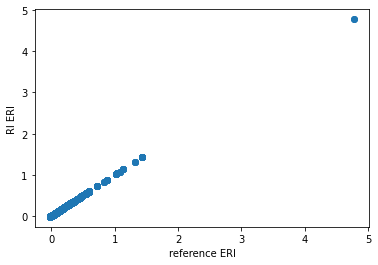

In [4]:
plt.scatter(μνλσ.flatten(), ref_μνλσ.flatten())
plt.xlabel("reference ERI")
plt.ylabel("RI ERI")
plt.show()

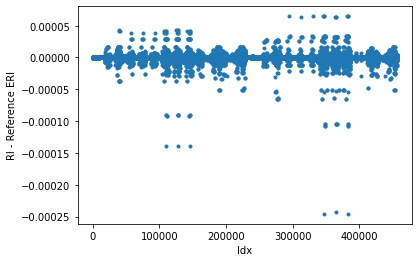

In [5]:
diff = μνλσ.flatten() - ref_μνλσ.flatten()
plt.plot(diff, '.')
plt.xlabel("Idx")
plt.ylabel("RI - Reference ERI")
plt.show()

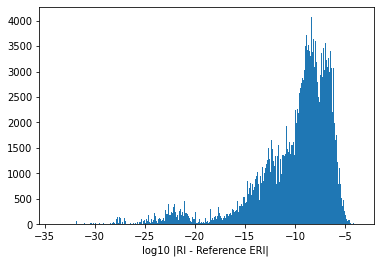

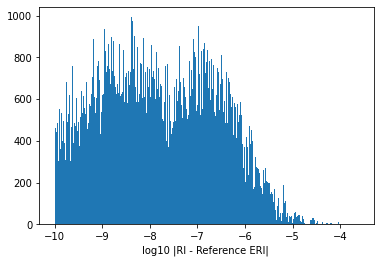

In [6]:
diff = μνλσ.flatten() - ref_μνλσ.flatten()
diff = diff[np.where(diff != 0 )]
diff = np.log10(np.abs(diff))

plt.hist(diff, bins=int(np.sqrt(diff.size)))
plt.xlabel( "log10 |RI - Reference ERI| " )
plt.show()

plt.hist(diff[np.where(diff>-10)], bins=int(np.sqrt(diff.size)))
plt.xlabel( "log10 |RI - Reference ERI| " )
plt.show()


In [12]:
tol = 1.e-4
p = 0
n = ref_μνλσ.shape[0]
n2,n3 = n**2,n**3
for idx, r in enumerate(ref_μνλσ.flatten()):
    v = μνλσ.flatten()[idx]
    if np.abs(v-r) > tol :
        i,j,k,l = idx//n3, (idx//n2)%n, (idx//n)%n, idx%n
        if p == 0 :
            print("IDX IJKL REF VAL DIF REL")
        print(idx, i,j,k,l,  r, v, r-v, (r-v)/(0.5*(np.abs(r+v)+np.abs(r-v))))
        p += 1
        if p == 32:
            break


IDX IJKL REF VAL DIF REL
109674 6 6 6 6 0.47883560463108976 0.47869641352194037 0.0001391911091493947 0.0002906866319112422
127953 7 7 7 7 0.47883560463108976 0.478695861898784 0.00013974273230576983 0.0002918386413922417
146232 8 8 8 8 0.47883560463108976 0.4786964135184358 0.0001391911126539802 0.00029068663923021657
347301 19 19 19 19 0.47883560463108976 0.47858983907033303 0.00024576556075672773 0.0005132566550602965
347978 19 20 19 20 0.029316465589658558 0.02921161830720031 0.00010484728245824942 0.0035763957335714614
348003 19 20 20 19 0.029316465589658558 0.02921161830720031 0.00010484728245824942 0.0035763957335714614
348655 19 21 19 21 0.029316465589658555 0.029209195670551812 0.00010726991910674222 0.0036590331388577043
348705 19 21 21 19 0.029316465589658555 0.029209195670551812 0.00010726991910674222 0.0036590331388577043
364878 20 19 19 20 0.029316465589658558 0.02921161830720031 0.00010484728245824942 0.0035763957335714614
364903 20 19 20 19 0.029316465589658558 0.029211

In [17]:
Amol._bas[np.where(Amol._bas[:,0]==0)]

array([[  0,   0,   1,   1,   0,  62,  63,   0],
       [  0,   0,   1,   1,   0,  64,  65,   0],
       [  0,   0,   1,   1,   0,  66,  67,   0],
       [  0,   0,   1,   1,   0,  68,  69,   0],
       [  0,   0,   1,   1,   0,  70,  71,   0],
       [  0,   0,   1,   1,   0,  72,  73,   0],
       [  0,   0,   1,   1,   0,  74,  75,   0],
       [  0,   0,   1,   1,   0,  76,  77,   0],
       [  0,   0,   1,   1,   0,  78,  79,   0],
       [  0,   0,   1,   1,   0,  80,  81,   0],
       [  0,   1,   1,   1,   0,  82,  83,   0],
       [  0,   1,   1,   1,   0,  84,  85,   0],
       [  0,   1,   1,   1,   0,  86,  87,   0],
       [  0,   1,   1,   1,   0,  88,  89,   0],
       [  0,   1,   1,   1,   0,  90,  91,   0],
       [  0,   1,   1,   1,   0,  92,  93,   0],
       [  0,   1,   1,   1,   0,  94,  95,   0],
       [  0,   2,   1,   1,   0,  96,  97,   0],
       [  0,   2,   1,   1,   0,  98,  99,   0],
       [  0,   2,   1,   1,   0, 100, 101,   0],
       [  0,   2,   

In [18]:
mol_h2o._bas[np.where(mol_h2o._bas[:,0]==0)]

array([[ 0,  0,  6,  1,  0, 52, 58,  0],
       [ 0,  0,  3,  1,  0, 64, 67,  0],
       [ 0,  0,  1,  1,  0, 70, 71,  0],
       [ 0,  1,  3,  1,  0, 72, 75,  0],
       [ 0,  1,  1,  1,  0, 78, 79,  0]], dtype=int32)